ETL Pipelines with Prefect
==========================

[Prefect](https://github.com/PrefectHQ/prefect) is a platform for automating data workflows.  Data engineers and data scientists can build, test and deploy production pipelines without worrying about all of the ["negative engineering" aspects](https://medium.com/the-prefect-blog/positive-and-negative-data-engineering-a02cb497583d) of production.  For example, Prefect makes it easy to deploy a workflow that runs on a complicated schedule, requires task retries in the event of failures, and sends notifications when certain tasks are complete.  Prefect was built on top of Dask, and [relies on Dask](http://stories.dask.org/en/latest/prefect-workflows.html#how-dask-helps) to schedule and manage the execution of a Prefect workflow in a distributed environment.

This example demonstrates running a Prefect ETL Flow on Dask which ultimately creates a GIF.  While this is a somewhat unconventional use case of Prefect, we're no strangers to [unconventional use cases](https://medium.com/the-prefect-blog/prefect-runs-on-prefect-3e6df553c3a4).

In the world of workflow engines, Prefect supports many unique features; in this particular example we will see:

- parametrization of workflows
- dynamic runtime "mapping" of workflow tasks
- customizable execution logic

You wouldn't get this from any other engine.

**Contents**

0. [Description of goal](#goal)
1. [Setting up our environment](#environment)
2. Building our Flow
    1. [Extract](#extract)
    1. [Transform](#transform)
    1. [Load](#load)
    1. [Putting the pieces together](#build)
3. [Running our Flow on Dask](#dask)
4. [Watching our GIF](#play)

<a id="goal"></a>

Goal
----

To demonstrate how Prefect and Dask work together, we are going to build and execute a standard "Extract / Transform / Load" (ETL) workflow for processing some basic image data.  Most ETL workflows involve a scheduled migration of data from one database to another.  In our case, we will be moving data from a file located at a known URL to our local hard disk, converting the individual file into a series of frames, and compiling those frames into a GIF.  The URL references a file containing raw bytes such as:

```python
b"""aÙw˜  ≠•∆≠≠ﬁ#!≠≠÷≠•Ω≠úΩ••µú•µîúµ•úΩ••Ω3&µ•Ω!µ≠∆≠•¥4(%µú∑≠≠Œ≠î≠≠≠∆≠îµúî≠úîµE5.≠ú≠≠•Œµµﬁ••∆•≠ŒµµŒúúΩ62&)1&623µ•∆Ωµ÷úî•ßjxΩΩÁú•Ωµ≠Œ••≠ú•≠Ω≠∆≠µÁâUV≠µ‹ΩµŒîî•NC5µ≠Ÿôãô•î•µ•µîú≠#VHCuhl≠≠ΩôchâRIoc]™≠Á≠î•™ú»öis•ú•f7,íYfL9?îî≠≠•÷∑ò™gWVxGEΩ≠–))1qB5µ≠Ω81R,´tÜñWV!HCDBB5;5?
"""
```

The steps of our workflow will be as follows:
- Extract: pull the data file from a URL (speicified by a `Parameter`) to disk
- Transform: split the file into multiple files, each corresponding to a single frame
- Load: Store each frame individually, and compile the frames together into a GIF

Once we have built our Flow, we can execute it with different values for the `Parameter` or even run it on a nightly schedule.

**NOTE:** If we planned on executing this Flow in a truly distributed environment, writing the images to the local filesystem would _not_ be appropriate.  We would instead use an external datastore such as Google Cloud Storage, or a proper database.

<a id="environment"></a>

Setting up our environment
--------------------------

Before proceeding, we need to install both the [`prefect`](https://pypi.org/project/prefect/) and [`imageio`](https://pypi.org/project/imageio/) packages.

In [1]:
!pip install imageio prefect[viz]

     |███████████████████▌            | 276 kB 3.2 MB/s eta 0:00:01

     |████████████████████████████████| 454 kB 3.2 MB/s 


     |████████████████████████████████| 46 kB 8.6 MB/s 


     |████████████████████████████████| 145 kB 10.3 MB/s 


     |██████▎                         | 30 kB 60.3 MB/s eta 0:00:01

     |████████████████████████████████| 155 kB 14.3 MB/s 


     |████████████████████████████████| 200 kB 13.3 MB/s 


     |████████████████████████████████| 78 kB 12.1 MB/s 


     |███████████████████████████▍    | 419 kB 14.5 MB/s eta 0:00:01

     |████████████████████████████████| 489 kB 14.5 MB/s 


 \ done
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=99fc719906a984e7159338a610d8e86c1c01fac0b82a70f96f772a3516a10a4a
  Stored in directory: /home/runner/.cache/pip/wheels/91/4d/4f/e740a68c215791688c46c4d6251770a570e8dfea91af1acb5c
Successfully built python-slugify


<a id="extract"></a>

### Extract

First, we will define our tasks for _extracting_ the image data file from a given URL and saving it to a given file location.  To do so, we will utilize two methods for creating Prefect Tasks:
- the `task` decorator for converting any Python function into a task
- a pre-written, configurable Task from the [Prefect "Task Library"](https://docs.prefect.io/guide/task_library/) which helps us abstract some standard boilerplate

Additionally, we will utilize the following Prefect concepts:
- a [Prefect signal](https://docs.prefect.io/guide/core_concepts/execution.html#state-signals) for marking this task and its downstream depedencies as successfully "Skipped" if the file is already present in our local filesystem
- retry semantics: if, for whatever reason, our `curl` command fails to connect, we want it to retry up to 2 times with a 10 second delay.  This way, if we run this workflow on a schedule we won't need to concern ourselves with temporary intermittent connection issues.

Right now we are simply defining our individual tasks - we won't actually set up our dependency structure until we create the full Flow.

In [2]:
import datetime
import os

import prefect
from prefect import task
from prefect.engine.signals import SKIP
from prefect.tasks.shell import ShellTask


@task
def curl_cmd(url: str, fname: str) -> str:
    """
    The curl command we wish to execute.
    """
    if os.path.exists(fname):
        raise SKIP("Image data file already exists.")
    return "curl -fL -o {fname} {url}".format(fname=fname, url=url)


# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

download = ShellTask(name="curl_task", max_retries=2, retry_delay=datetime.timedelta(seconds=10))

<a id="transform"></a>

### Transform

Next up, we need to define our task which loads the image data file and splits it into multiple frames.  In this case, each frame is delimited by 4 newlines.  Note that, in the event the previous two tasks are "Skipped", the default behavior in Prefect is to skip downstream dependencies as well.  However, as with most things in Prefect, this behavior is customizable.  In this case, we want this task to run regardless of whether the upstreams skipped or not, so we set the `skip_on_upstream_skip` flag to `False`.

In [3]:
@task(skip_on_upstream_skip=False)
def load_and_split(fname: str) -> list:
    """
    Loads image data file at `fname` and splits it into
    multiple frames.  Returns a list of bytes, one element
    for each frame.
    """
    with open(fname, "rb") as f:
        images = f.read()
        
    return [img for img in images.split(b"\n" * 4) if img]

<a id="load"></a>

### Load

Finally, we want to write our frames to disk as well as combine the frames into a single GIF.  In order to achieve this goal, we are going to utilize [Prefect's task "mapping" feature](https://docs.prefect.io/guide/core_concepts/mapping.html) which conveniently spawns new tasks in response to upstream outputs.  In this case, we will write a single task for writing an image to disk, and "map" this task over all the image frames returned by `load_and_split` above!  To infer which frame we are on, we look in [`prefect.context`](https://docs.prefect.io/guide/core_concepts/execution.html#context).

Additionally, we can "reduce" over a mapped task - in this case, we will take the collection of mapped tasks and pass them into our `combine_to_gif` task for creating and saving our GIF.

In [4]:
@task
def write_to_disk(image: bytes) -> bytes:
    """
    Given a single image represented as bytes, writes the image
    to the present working directory with a filename determined
    by `map_index`.  Returns the image bytes.
    """
    frame_no = prefect.context.get("map_index")
    with open("frame_{0:0=2d}.gif".format(frame_no), "wb") as f:
        f.write(image)
    return image

In [5]:
import imageio
from io import BytesIO


@task
def combine_to_gif(image_bytes: list) -> None:
    """
    Given a list of ordered images represented as bytes,
    combines them into a single GIF stored in the present working directory.
    """
    images = [imageio.imread(BytesIO(image)) for image in image_bytes]
    imageio.mimsave('./clip.gif', images)

<a id="build"></a>

Build the Flow
---------------

Finally, we need to put our tasks together into a Prefect "Flow".  Similar to Dask's `delayed` interface, all computation is deferred and no Task code will be executed in this step.  Because Prefect maintains a stricter contract between tasks and additionally needs the ability to run in non-Dask execution environments, the mechanism for deferring execution is independent of Dask.

In addition to the tasks we have already defined, we introduce two "Parameters" for specifying the URL and local file location of our data.  At runtime, we can optionally override these tasks to return different values.

Unable to revert mtime: /usr/share/fonts/cMap
Unable to revert mtime: /usr/share/fonts/cmap/adobe-cns1
Unable to revert mtime: /usr/share/fonts/cmap/adobe-gb1
Unable to revert mtime: /usr/share/fonts/cmap/adobe-japan1
Unable to revert mtime: /usr/share/fonts/cmap/adobe-japan2
Unable to revert mtime: /usr/share/fonts/cmap/adobe-korea1


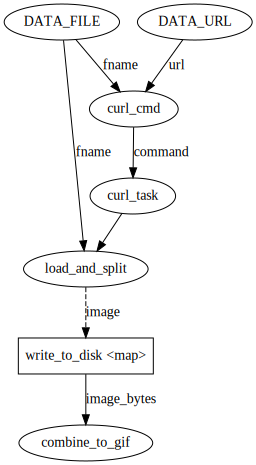

In [6]:
from prefect import Parameter, Flow


DATA_URL = Parameter("DATA_URL", 
                     default="https://github.com/cicdw/image-data/blob/master/all-images.img?raw=true")

DATA_FILE = Parameter("DATA_FILE", default="image-data.img")


with Flow("Image ETL") as flow:
    
    # Extract
    command = curl_cmd(DATA_URL, DATA_FILE)
    curl = download(command=command)
    
    # Transform
    # we use the `upstream_tasks` keyword to specify non-data dependencies
    images = load_and_split(fname=DATA_FILE, upstream_tasks=[curl])
    
    # Load  
    frames = write_to_disk.map(images)
    result = combine_to_gif(frames)
    

flow.visualize()

<a id="dask"></a>

### Running the Flow on Dask

Now we have built our Flow, independently of Dask.  We could execute this Flow sequentially, Task after Task, but there is inherent parallelism in our mapping of the images to files that we want to exploit.  Luckily, Dask makes this easy to achieve.

First, we will start a local Dask cluster.  Then, we will run our Flow against Prefect's `DaskExecutor`, which will submit each Task to our Dask cluster and use Dask's distributed scheduler for determining when and where each Task should run.  Essentially, we built a Directed Acylic Graph (DAG) and are simply "submitting" that DAG to Dask for handling its execution in a distributed way.

In [7]:
# start our Dask cluster
from dask.distributed import Client


client = Client(n_workers=4, threads_per_worker=1)

# point Prefect's DaskExecutor to our Dask cluster

from prefect.engine.executors import DaskExecutor

executor = DaskExecutor(address=client.scheduler.address)
flow.run(executor=executor)

[2020-11-05 10:39:30] INFO - prefect.FlowRunner | Beginning Flow run for 'Image ETL'


/usr/share/miniconda3/envs/dask-examples/lib/python3.8/site-packages/distributed/worker.py:3373: UserWarning: Large object of size 2.03 MB detected in task graph: 
  {'task': <Task: write_to_disk>, 'state': None, 'up ... _parent': True}
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


[2020-11-05 10:39:34] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


<Success: "All reference tasks succeeded.">

Next Steps
----------

Now that we've built our workflow, what next?  The interested reader should try to:

- run the Flow again to see how the `SKIP` signal behaves
- use different parameters for both the URL and the file location (Parameter values can be overriden by simply passing their names as keyword arguments to `flow.run()`)
- introduce a new Parameter for the filename of the final GIF
- use Prefect's [scheduler interface](https://docs.prefect.io/guide/core_concepts/schedules.html) to run our workflow on a schedule

<a id="play"></a>

Play
----

Finally, let's watch our creation!

In [8]:
from IPython.display import HTML

HTML('<img src="./clip.gif" alt="Rick Daskley">')